In [1]:
import pandas as pd

# Read the data into a DataFrame'
df = pd.read_csv("../../data/raw/sales_train.csv")

In [2]:
df.shape

(30490, 1547)

In [3]:
df.drop(["id", "dept_id", "cat_id", "state_id"], inplace=True, axis=1)

In [4]:
# Define the minimum percentage of non-zero days to keep an item
min_non_zero_percentage = 10  # Adjust as needed

total_days = 1541

# Calculate the percentage of non-zero days for each item
df['non_zero_percentage'] = (df.iloc[:, 2:] > 0).sum(axis=1) / total_days * 100

# Filter the DataFrame to keep only items with non-zero percentage >= min_non_zero_percentage
df_filtered = df[df['non_zero_percentage'] >= min_non_zero_percentage]

# Drop the 'non_zero_percentage' column if no longer needed
df_filtered = df_filtered.drop(columns=['non_zero_percentage'])

In [5]:
# Check if all 'd_' columns have zeros, and keep items that were sold at least once
#df_filtered = df[df.iloc[:, 2:].sum(axis=1) > 0]

In [6]:
df_filtered = df_filtered.melt(id_vars=['item_id', 'store_id'], var_name='d', value_name='units_sold')

In [7]:
df_filtered.head()

,item_id,store_id,d,units_sold
0,HOBBIES_1_001,CA_1,d_1,0
1,HOBBIES_1_002,CA_1,d_1,0
2,HOBBIES_1_004,CA_1,d_1,0
3,HOBBIES_1_005,CA_1,d_1,0
4,HOBBIES_1_006,CA_1,d_1,0


In [8]:
del df

In [9]:
df_filtered.shape

(35604805, 4)

In [10]:
df_filtered['item_id'] = df_filtered['item_id'].astype("category")

In [11]:
df_filtered['store_id'] = df_filtered['store_id'].astype("category")

In [12]:
cal = pd.read_csv("../../data/raw/calendar.csv")
items_price = pd.read_csv("../../data/raw/items_weekly_sell_prices.csv")

In [13]:
cal.head()

,date,wm_yr_wk,d
0,2011-01-29,11101,d_1
1,2011-01-30,11101,d_2
2,2011-01-31,11101,d_3
3,2011-02-01,11101,d_4
4,2011-02-02,11101,d_5


In [14]:
items_price.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [15]:
df_cal = df_filtered.merge(cal[['d', 'date', 'wm_yr_wk']], on='d', how='left')
df_cal['date'] = pd.to_datetime(df_cal['date'])

In [16]:
df_cal.drop(["d"], inplace=True, axis=1)

In [17]:
del df_filtered

In [18]:
df_cal.head()

,item_id,store_id,units_sold,date,wm_yr_wk
0,HOBBIES_1_001,CA_1,0,2011-01-29,11101
1,HOBBIES_1_002,CA_1,0,2011-01-29,11101
2,HOBBIES_1_004,CA_1,0,2011-01-29,11101
3,HOBBIES_1_005,CA_1,0,2011-01-29,11101
4,HOBBIES_1_006,CA_1,0,2011-01-29,11101


In [19]:
df_cal.shape

(35604805, 5)

In [20]:
df_merged = df_cal.merge(items_price, on=['wm_yr_wk', 'item_id', 'store_id'], how='inner')

In [21]:
df_merged.sample(5)

,item_id,store_id,units_sold,date,wm_yr_wk,sell_price
2706613,HOUSEHOLD_2_209,WI_3,0,2011-08-13,11129,8.47
18754830,FOODS_1_208,CA_2,4,2013-12-24,11348,1.78
4706221,FOODS_3_721,WI_2,0,2011-12-26,11148,1.98
12599217,HOUSEHOLD_2_492,CA_2,2,2013-03-10,11307,5.92
19078414,FOODS_1_067,CA_3,0,2014-01-09,11350,1.78


In [22]:
df_merged.shape

(29827642, 6)

In [23]:
df_merged[["units_sold", "wm_yr_wk"]] = df_merged[["units_sold", "wm_yr_wk"]].apply(pd.to_numeric, downcast="float")

In [24]:
df_merged["revenue"] = df_merged["units_sold"]*df_merged["sell_price"]

In [25]:
df_merged.head()

,item_id,store_id,units_sold,date,wm_yr_wk,sell_price,revenue
0,HOBBIES_1_008,CA_1,12.0,2011-01-29,11101.0,0.46,5.52
1,HOBBIES_1_008,CA_1,15.0,2011-01-30,11101.0,0.46,6.90
2,HOBBIES_1_008,CA_1,0.0,2011-01-31,11101.0,0.46,0.00
3,HOBBIES_1_008,CA_1,0.0,2011-02-01,11101.0,0.46,0.00
4,HOBBIES_1_008,CA_1,0.0,2011-02-02,11101.0,0.46,0.00


In [26]:
df_merged.drop(["wm_yr_wk", "units_sold"], inplace=True, axis=1)

In [27]:
del df_cal

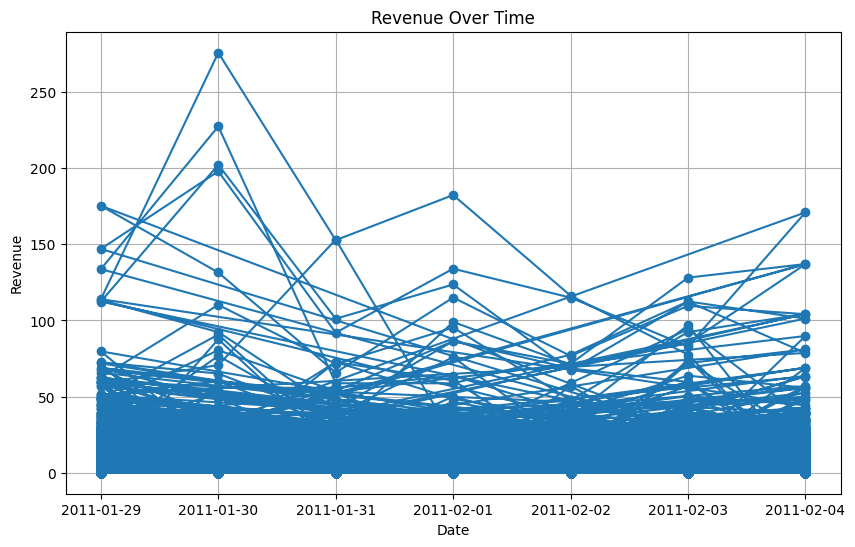

In [30]:
import matplotlib.pyplot as plt
# Convert 'date' column to datetime
df_merged['date'] = pd.to_datetime(df_merged['date'])
subset_df = df_merged.head(10000)
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(subset_df['date'], subset_df['revenue'], marker='o')
plt.title('Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(True)

# Show the plot
plt.show()

In [28]:
def get_date_features(df_merged):
    df = df_merged.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.dayofweek
    return df.drop(["date"], axis=1)

In [29]:
df_cleaned = get_date_features(df_merged)

In [30]:
df_cleaned.head()

,item_id,store_id,sell_price,revenue,year,month,day,weekday
0,HOBBIES_1_008,CA_1,0.46,5.52,2011,1,29,5
1,HOBBIES_1_008,CA_1,0.46,6.90,2011,1,30,6
2,HOBBIES_1_008,CA_1,0.46,0.00,2011,1,31,0
3,HOBBIES_1_008,CA_1,0.46,0.00,2011,2,1,1
4,HOBBIES_1_008,CA_1,0.46,0.00,2011,2,2,2


In [34]:
df_cleaned["revenue"].value_counts()

0.00      16405658
2.98        245999
1.98        232301
3.98        178698
5.96        156733
            ...   
110.74           1
30.10            1
37.17            1
197.46           1
41.01            1
Name: revenue, Length: 9381, dtype: int64

In [31]:
df_cleaned = df_cleaned[df_cleaned['revenue'] != 0]

In [32]:
df_cleaned.shape

(13421984, 8)

## Modelling

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV,  KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

In [34]:
"""import dask.dataframe as dd
# Convert the Pandas DataFrame to a Dask DataFrame
ddf = dd.from_pandas(df_cleaned, npartitions=4)

# Define categorical and numerical columns
categorical_columns = ['item_id', 'store_id']
numerical_columns = ['year', 'month', 'day', 'weekday']

ddf[numerical_columns] = ddf[numerical_columns].astype('float32')

# Splitting data into X (features) and y (target variable)
X = ddf.drop(columns=['revenue']).compute()
y = ddf['revenue'].compute()
"""

# Define categorical and numerical columns
categorical_columns = ['item_id', 'store_id']
numerical_columns = ['sell_price', 'year', 'month', 'day', 'weekday']

# Splitting data into X (features) and y (target variable)
X = df_cleaned.drop(columns=['revenue'])
y = df_cleaned['revenue']

In [35]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns),
    ])

# Fit the preprocessing pipeline on the Dask DataFrame
#preprocessor.fit(ddf.compute())

# Model pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SGDRegressor(loss='squared_error', penalty = "elasticnet", 
                               early_stopping=True,  # Enable early stopping
                               max_iter=10000, tol=1e-3, alpha=0.001,
                            validation_fraction=0.2,  # Fraction of training data used for validation
                            n_iter_no_change=10  # Number of iterations with no improvement on validation set
    ))
    
])


In [36]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['sell_price', 'year',
                                                   'month', 'day', 'weekday']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['item_id', 'store_id'])])),
                ('regressor',
                 SGDRegressor(alpha=0.001, early_stopping=True, max_iter=10000,
                              n_iter_no_change=10, penalty='elasticnet',
                              validation_fraction=0.2))])

In [37]:
# Evaluate the model on the test set
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

Mean Squared Error on Test Set: 142.86198814487236


In [38]:
max(y_pred)

84.09492358736179

In [43]:
# Now you can use the pipeline for prediction
# For example, to predict the sales for a new data point:
new_data = pd.DataFrame({'item_id': ['HOBBIES_1_060'], 'store_id': ['CA_1'], 'sell_price': [30.98], 'date': ['2012-05-19']})

In [44]:
new_data = get_date_features(new_data)

In [45]:
new_data

,item_id,store_id,sell_price,year,month,day,weekday
0,HOBBIES_1_060,CA_1,30.98,2012,5,19,5


In [46]:
predicted_sales = pipeline.predict(new_data)
print(predicted_sales)

[45.23568832]


## Save model

In [48]:
from joblib import dump

dump(pipeline, '../../models/predictive/sgd_pipeline.joblib')

['../../models/predictive/sgd_pipeline.joblib']

## Appendix

In [41]:
# Define a custom transformer to extract date features
class DateFeaturesExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['date'] = pd.to_datetime(X['date'])
        X['year'] = X['date'].dt.year
        X['month'] = X['date'].dt.month
        X['day'] = X['date'].dt.day
        X['weekday'] = X['date'].dt.weekday
        return X.drop(columns=['date'])

# Specify numerical and categorical columns
numerical_columns = ['year', 'month', 'day', 'weekday']
categorical_columns = ['item_id', 'store_id']

# Preprocessing pipeline for date features
date_feature_transformer = Pipeline([
    ('date_features', DateFeaturesExtractor()),
    ('scaler', StandardScaler())
])

# Preprocessing pipeline for categorical features
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

# Combine transformers for date and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', date_feature_transformer, ['date']),
        ('cat', categorical_transformer, categorical_columns),
    ])

# Model pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SGDRegressor())
])

# Separate features (X) and target (y)
X = df.drop(columns=['volume of sales'])
y = df['volume of sales']

# Fit the pipeline on your data
pipeline.fit(X, y)

# Now you can use the trained pipeline for prediction


ValueError: A given column is not a column of the dataframe

In [ ]:
# Hyperparameter grid for grid search
param_grid = {
    'regressor__alpha': [0.0001, 0.001, 0.01, 0.1],
    'regressor__max_iter': [1000, 5000, 10000],
}

# Grid search with cross-validation
#cv = KFold(n_splits=5, shuffle=True, random_state=42)  # Use KFold for regression
grid_search = GridSearchCV(
    pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search.fit(X, y)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Fit the model with the best hyperparameters
final_pipeline = grid_search.best_estimator_
final_pipeline.fit(X_train, y_train)

In [ ]:
# Evaluate the model on the test set
y_pred = final_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)